# Stocks and Deep Learning = 🤯

Here we will be using `AAPL` stock data, because, you know, nowadays they have launched the iPhone 14 and we want to see how Apple's price get up or down in the future.

I will be taking the real data from the library instead of using the .csv file to do the job. Let's go.

In [1]:
# don't worry about the code below... it is just the boilerplate code.

# usual imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams["figure.figsize"] = (8, 6)

# data fetch api
pd.core.common.is_list_like = pd.api.types.is_list_like
from datetime import datetime, timedelta
from itertools import product
import pandas_datareader.data as web


# sklearn related
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
    r2_score,
)

# Neural network related imports
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

In [4]:
# In pandas, just done in the simple one line of code
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import yfinance as yf

In [5]:
# initializing Parameters
start = "2020-01-01"
end = "2024-04-30"
symbols = ["AAPL"]

# Get data
data = yf.download(symbols, start, end)

[*********************100%%**********************]  1 of 1 completed


In [7]:
data = data.reset_index()
df = data[["Close", "Date"]].set_index("Date")
df.head()

,Close
Date,
2020-01-02,75.087502
2020-01-03,74.357498
2020-01-06,74.949997
2020-01-07,74.597504
2020-01-08,75.797501


Start: Year, Month, Day
2020-01-01


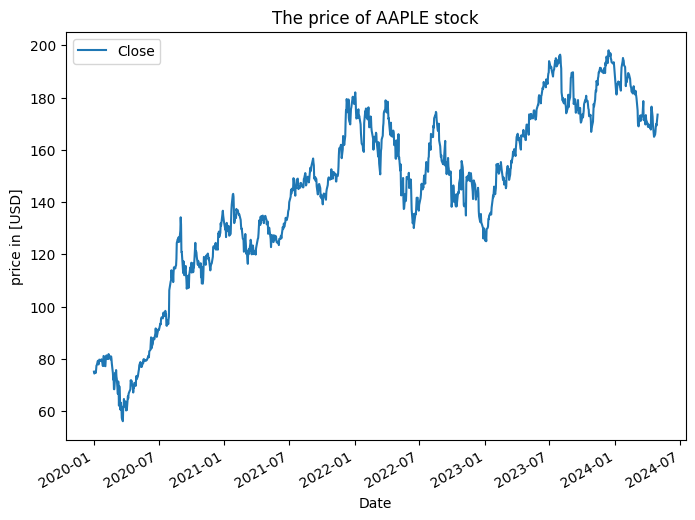

In [8]:
print("Start: Year, Month, Day")
print(str(start))
df.plot(label=stock)
plt.legend()
plt.ylabel("price in [USD]")

plt.title("The price of AAPLE stock")
plt.show();

In [9]:
df.tail(1)

,Close
Date,
2024-04-29,173.5


So, just yesterday — APPL was at `157.36` price.

Since this data has trend and volatility... we would really like to perform differencing.

In [10]:
df["DiffClose"] = df.diff()

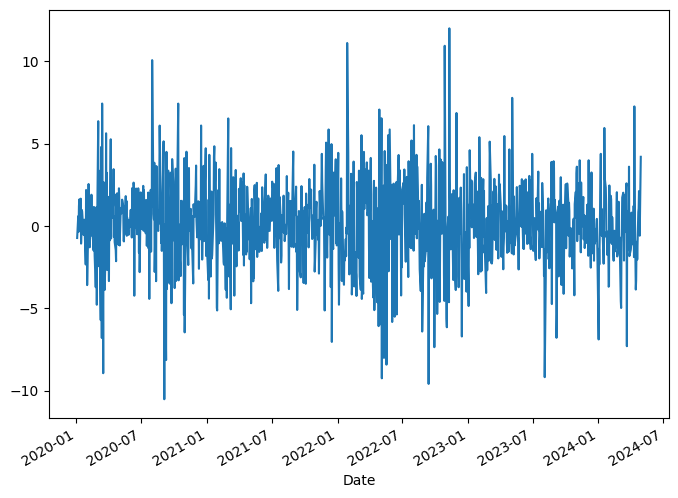

In [11]:
df["DiffClose"].plot();

### 🤚 Before moving forward!
The author also suggested to ***standardize*** the time-series data. Because, neural networks **works better** with the standardized data! Just like linear regression or other models in ML.

Now, we have `2` options:
1. Standardize data **as a whole** (linear-ly, as a single column)
2. Standardize data **after transforming** it as a supervised data.

The **second** looks familiar, right? But **NO**.
___

Because the second approach will have **different** value for a same data point in different columns. Which should not be a case. So, we will standardize with the first approach only.

I know, it is the first time in the time-series... but let's try.

In [12]:
testSize = 31
train_idx = df.iloc[:-testSize].index
test_idx = df.iloc[-testSize:].index

In [13]:
scaler = StandardScaler()
df.loc[train_idx, "ScaledDiffClose"] = scaler.fit_transform(
    df.loc[train_idx, ["DiffClose"]]).flatten()
df.loc[test_idx, "ScaledDiffClose"] = scaler.transform(
    df.loc[test_idx, ["DiffClose"]]).flatten()

We are done with the scaling... let's get ahead.

In [14]:
# Check the R2 and MAE
def get_metrics(true, forecast):
    print("MAPE:", round(mean_absolute_percentage_error(true, forecast) * 100, 4), "%")
    print("MAE:", mean_absolute_error(true, forecast))
    print("RMSE:", mean_squared_error(true, forecast, squared=False))

# `1.` One-Step

#### Data preparation

In [15]:
lag = 10
np_data = df.loc[:, "ScaledDiffClose"].dropna().values
X = []
Y = []

for i in range(0, np_data.shape[0] - lag):
    x = np_data[i : i + lag]
    y = np_data[i + lag]
    X.append(x)
    Y.append(y)

X = np.array(X)
Y = np.array(Y)

In [16]:
Xtr, Xte = X[:-testSize], X[-testSize:]
ytr, yte = Y[:-testSize], Y[-testSize:]

#### Model creation

In [17]:
input_layer = Input(Xtr.shape[1])
hidden_layer = Dense(64, activation="relu")(input_layer)
hidden_layer = Dense(32, activation="relu")(hidden_layer)
output_layer = Dense(1)(hidden_layer)
model = Model(input_layer, output_layer)

In [18]:
# compile
model.compile(optimizer="adam", loss="mse")

In [19]:
# This will show the neat progress bar.
from tqdm.keras import TqdmCallback

In [20]:
# fit
result = model.fit(Xtr, ytr,
         epochs=200,
         validation_data=(Xte, yte),
        verbose=0, callbacks=[TqdmCallback(verbose=0)])

0epoch [00:00, ?epoch/s]

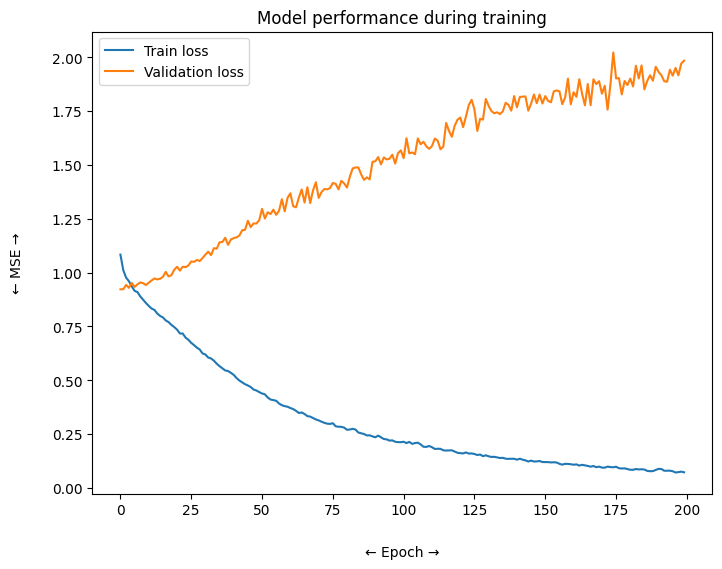

In [21]:
plt.plot(result.history['loss'], label="Train loss")
plt.plot(result.history['val_loss'], label="Validation loss")
plt.xlabel("← Epoch →", labelpad=20)
plt.ylabel("← MSE →", labelpad=20)
plt.title("Model performance during training")
plt.legend();

Have a look! How easily it overfits.

In [22]:
pred_tr = model.predict(Xtr).flatten()
pred_te = model.predict(Xte).flatten()

# to undo differencing
prev = df["Close"].shift(1)

1/1 [==============================] - 0s 36ms/step


In [23]:
# have to perform it because we have converted the scale before

pred_tr = scaler.inverse_transform(pred_tr.reshape(-1, 1))
pred_te = scaler.inverse_transform(pred_te.reshape(-1, 1))

In [24]:
df.loc[train_idx[lag+1:], "OneStep Orig Train Pred"] = prev[train_idx[lag+1:]] + pred_tr.flatten()
df.loc[test_idx, "OneStep Orig Test Pred"] = prev[test_idx] + pred_te.flatten()

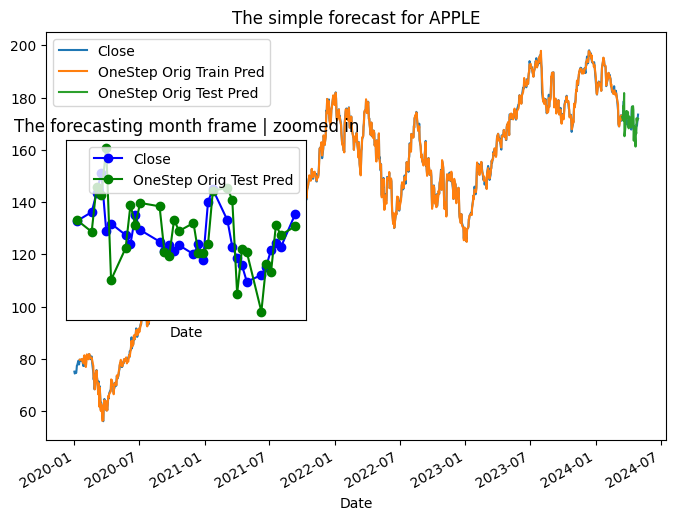

In [25]:
main_axes = plt.axes()
small_axes = plt.axes([.15,.4,.3,.3])

df[["Close", "OneStep Orig Train Pred", "OneStep Orig Test Pred"]].plot(ax=main_axes)
df[["Close", "OneStep Orig Test Pred"]].iloc[-testSize:].plot(ax=small_axes,
                                                              marker='o',
                                                              color=["blue", "green"])

main_axes.set(title="The simple forecast for APPLE");
small_axes.set(yticks=[], xticks=[],
               title="The forecasting month frame | zoomed in");

In [26]:
get_metrics(df.loc[test_idx, "Close"], df.loc[test_idx, "OneStep Orig Test Pred"])

MAPE: 1.7169 %
MAE: 2.926916410365412
RMSE: 3.704879521964392


Man! Looks cool! It is not **that** bad! But... remember! **THIS IS THE ONE-STEP**. We don't have to get fooled by its accuracy.

# `2.` Multi-Step Model

In [27]:
last_xte = Xte[0].reshape(1, -1)
multi_step_pred = []
for i in range(yte.shape[0]):
    pred = model.predict(last_xte)[0]
    last_xte = np.roll(last_xte, -1)
    last_xte[-1][-1] = pred
    multi_step_pred.append(pred)

1/1 [==============================] - 0s 19ms/step


<ipython-input-27-a10601a2694b>:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_xte[-1][-1] = pred


1/1 [==============================] - 0s 21ms/step


In [28]:
# to have things on the original scale
multi_step_pred = scaler.inverse_transform(np.reshape(multi_step_pred, (-1, 1)))

In [29]:
df.loc[test_idx, "MultiStep Test Prediction"] = multi_step_pred.flatten()

In [30]:
# to undo
last_train = df.loc[train_idx[-1], "Close"]

In [31]:
df.loc[test_idx, "MultiStep Orig Test Pred"] = last_train + np.cumsum(multi_step_pred)

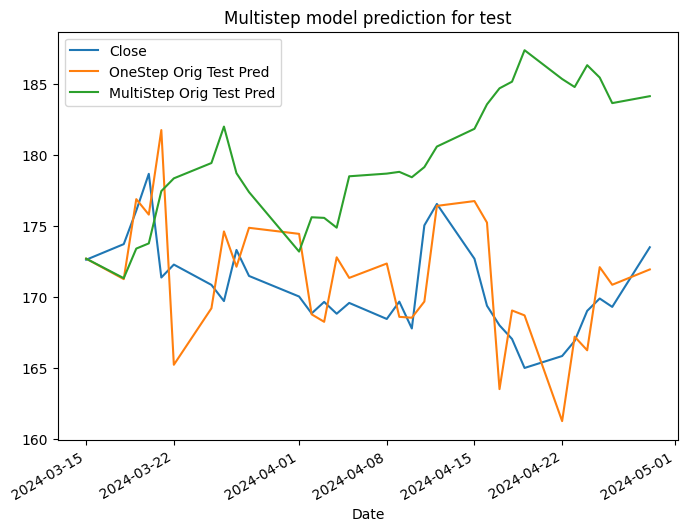

In [32]:
df.iloc[-testSize:][["Close", "OneStep Orig Test Pred", "MultiStep Orig Test Pred"]].plot()
plt.title("Multistep model prediction for test");

In [33]:
get_metrics(df.loc[test_idx, "Close"], df.loc[test_idx, "MultiStep Orig Test Pred"])

MAPE: 5.7012 %
MAE: 9.650003248645413
RMSE: 11.209336024780566


# `3.` Multi output model

In [34]:
# for this we will have to construct another dataset
# the current supervised dataset won't help.

lag = lag
h = testSize
X, y = [], []
for offset in range(len(np_data) - lag - h + 1):
    X.append(np_data[offset : offset+lag])
    y.append(np_data[offset+lag : offset+lag+h])

X = np.array(X)
y = np.array(y)

In [35]:
Xtr_m, ytr_m = X[:-1], y[:-1]
Xte_m, yte_m = X[[-1]], y[[-1]]

In [36]:
Xtr_m.shape

(1046, 10)

In [37]:
ytr_m.shape

(1046, 31)

### Model creation

In [38]:
input_layer = Input(shape=(Xtr_m.shape[1], ))
h1 = Dense(64, activation="relu")(input_layer)
h1 = Dense(32, activation="relu")(h1)
output_layer = Dense(ytr_m.shape[1])(h1)
model = Model(input_layer, output_layer)

In [39]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_3 (Dense)             (None, 64)                704       
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 31)                1023      
                                                                 
Total params: 3807 (14.87 KB)
Trainable params: 3807 (14.87 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [40]:
# compile
model.compile(optimizer="adam", loss="mse")

In [41]:
# fit
mtr_result = model.fit(Xtr_m, ytr_m,
         epochs=200,
         validation_data=(Xte_m, yte_m),
         verbose=0, callbacks=[TqdmCallback(verbose=0)])

0epoch [00:00, ?epoch/s]

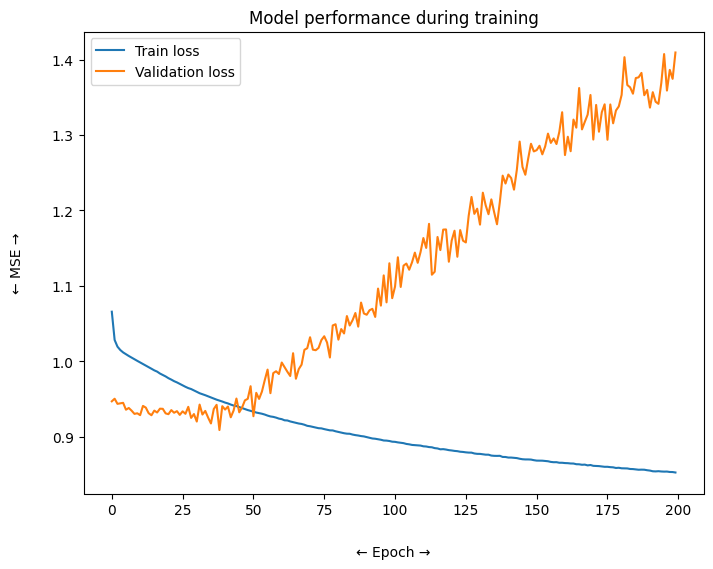

In [42]:
plt.plot(mtr_result.history['loss'], label="Train loss")
plt.plot(mtr_result.history['val_loss'], label="Validation loss")
plt.xlabel("← Epoch →", labelpad=20)
plt.ylabel("← MSE →", labelpad=20)
plt.title("Model performance during training")
plt.legend();

In [43]:
mtr_test_pred = model.predict(Xte_m)

1/1 [==============================] - 0s 56ms/step


In [44]:
mtr_test_pred = scaler.inverse_transform(mtr_test_pred.reshape(-1, 1))

In [45]:
df.loc[test_idx, "MultiOutput Orig Test Pred"] = last_train + np.cumsum(mtr_test_pred.flatten())

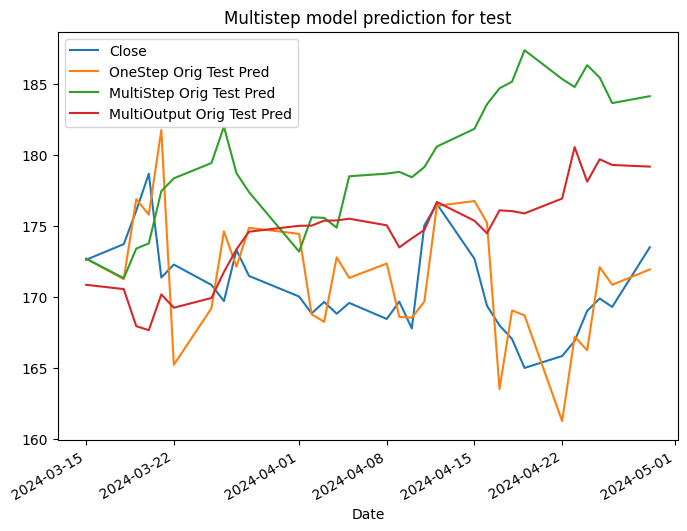

In [46]:
df.iloc[-testSize:][["Close", "OneStep Orig Test Pred", "MultiStep Orig Test Pred", "MultiOutput Orig Test Pred"]].plot()
plt.title("Multistep model prediction for test");

In [47]:
get_metrics(df.loc[test_idx, "Close"], df.loc[test_idx, "MultiOutput Orig Test Pred"])

MAPE: 3.3487 %
MAE: 5.68170658234627
RMSE: 6.761822709712616


Not the great, nor  the best... but here is how it goes.

#

## 😮 Something new. This time.
We will be doing the **binary classification** for the stocks. **Classification???** ***YESS***.

> We will predict *will the stock go up* or *will it go down*. <br> That's it. The binary classification.

We have the targets...

In [48]:
ytr

array([ 0.29649591, -0.24057812,  0.07216002, ...,  0.14725292,
       -0.83372959,  0.67576927])

Which are the differenced version and **ofcourse** if they are negative then the **decrease** is observed and if they are **positive** then the increase is observed.

To make it more clear... suppose `prices = [0, 5, 2, 5]` is given... so the difference would be `diff = [nan, 5, -3, 3]`. And hence, whenever we have the **+ve** values we have rise and vice-versa.

In [49]:
ytr_clf = np.where(ytr < 0, 0, 1)
yte_clf = np.where(yte < 0, 0, 1)

In [50]:
ytr_clf

array([1, 0, 1, ..., 1, 0, 1])

Now, let's build the model.

> And, yes... this is gonna be the **one-step** model only. Because we will only see what is gonna happen on the next day. Yes, we can use the other model to **first** forecast the future and then **based on them** we can use **this** model... but for now, we will stick to the one-step only.

In [51]:
input_layer = Input(shape=(Xtr.shape[1], ))
hidden_layer = Dense(32, activation="relu")(input_layer)
hidden_layer = Dense(32, activation="relu")(hidden_layer)
output_layer = Dense(1, activation="sigmoid")(hidden_layer) # used sigmoid here.
model = Model(input_layer, output_layer)

In [52]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_6 (Dense)             (None, 32)                352       
                                                                 
 dense_7 (Dense)             (None, 32)                1056      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1441 (5.63 KB)
Trainable params: 1441 (5.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Great so far.

In [53]:
model.compile(optimizer="adam", loss="mse", metrics=["accuracy"])

In [54]:
clf_results = model.fit(Xtr, ytr_clf,
                          epochs=100,
                          validation_data=(Xte, yte_clf),
                          verbose=0, callbacks=[TqdmCallback(verbose=0)])

0epoch [00:00, ?epoch/s]

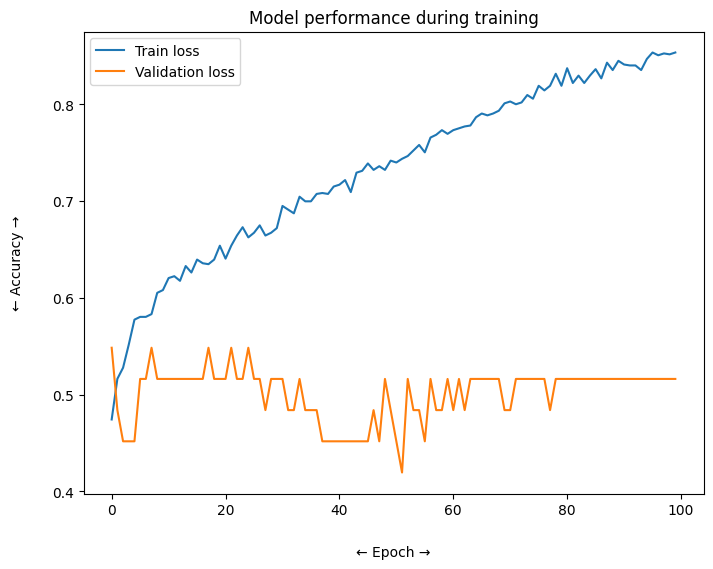

In [55]:
plt.plot(clf_results.history['accuracy'], label="Train loss")
plt.plot(clf_results.history['val_accuracy'], label="Validation loss")
plt.xlabel("← Epoch →", labelpad=20)
plt.ylabel("← Accuracy →", labelpad=20)
plt.title("Model performance during training")
plt.legend();

We can see that... the maximum accuracy that the model can capture is like ~60%. Which is more than just the **random** guess. But that is still not sufficient.

#### There is something new.
While fitting, we can set **another** loss function which **should be** used in the classification scenario.

In [56]:
from tensorflow.keras.losses import BinaryCrossentropy

In [57]:
input_layer = Input(shape=(Xtr.shape[1], ))
hidden_layer = Dense(32, activation="relu")(input_layer)
hidden_layer = Dense(32, activation="relu")(hidden_layer)
output_layer = Dense(1, activation="sigmoid")(hidden_layer) # used sigmoid here.
model = Model(input_layer, output_layer)

In [58]:
model.compile(optimizer="adam",
              loss=BinaryCrossentropy(from_logits=True), ### This one ###
              metrics=["accuracy"])

In [59]:
clf_results = model.fit(Xtr, ytr_clf,
                          epochs=100,
                          validation_data=(Xte, yte_clf),
                          verbose=0, callbacks=[TqdmCallback(verbose=0)])

0epoch [00:00, ?epoch/s]

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


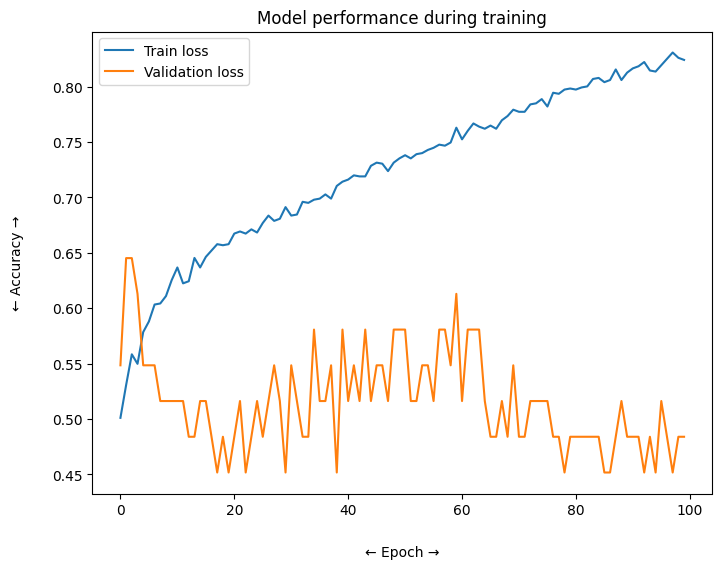

In [60]:
plt.plot(clf_results.history['accuracy'], label="Train loss")
plt.plot(clf_results.history['val_accuracy'], label="Validation loss")
plt.xlabel("← Epoch →", labelpad=20)
plt.ylabel("← Accuracy →", labelpad=20)
plt.title("Model performance during training")
plt.legend();

Similar... but good enough.

#

# Have seen great things,
Next up, we will go for more. Even more. Getting wild. I know.